## PS8
### Li Ruixue

#### (a) Create a scatterplot of the data where the x-variable is alcohol (alco) and the y-variable is color intensity (color int). Make the dot of each of the three possible cultivar types a dierent color. Make sure your plot has a legend.

In [194]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline


In [195]:
df = pd.read_csv('../../ProblemSets/PS8/data/strongdrink.txt')

In [196]:
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


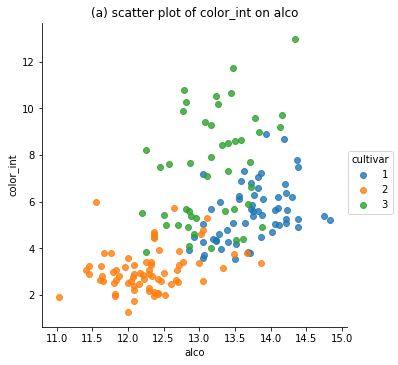

In [197]:
%matplotlib inline
g = sns.lmplot('alco','color_int', df, hue = 'cultivar', fit_reg = False)
ax = plt.gca()
ax.set_title("(a) scatter plot of color_int on alco")
plt.show()

#### (b) Use sklearn.linear model.LogisticRegression to fit a multinomial logistic model of cultivar on features alcohol (alco), malic acid (malic), total phenols (tot phen), and color intensity (color int) with the following linear predictor.

In [198]:
Xvars = df[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = df['cultivar'].values

k = 4
kf = KFold(n_splits=k, random_state=22, shuffle=True)
kf.get_n_splits(Xvars)

def get_MSE(penalty, C):
    MSE_vec_kf = np.zeros(k)
    k_ind = int(0)
    for train_index, test_index in kf.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        # saga is the only solver that supports both penalties and multi_class
        LogReg = LogisticRegression(fit_intercept=True, penalty=penalty, C = C, solver = 'saga', 
                                   multi_class = 'multinomial')
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        MSE_vec_kf[k_ind] = ((y_test != y_pred)).mean()
        k_ind += 1
    MSE_kf = MSE_vec_kf.mean()
    return MSE_kf

In [199]:
c_range = np.arange(0.001,2.001, 0.01)
MSE = []
for p in ['l1','l2']:
    for c in c_range:
        MSE.append([p, c, get_MSE(p, c)])
MSE_df = pd.DataFrame(MSE, columns = ['penalty','c', 'MSE'])

Text(0.5,1,'(a) MSE on C')

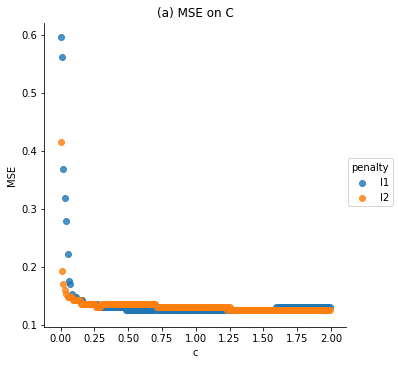

In [200]:
g = sns.lmplot('c','MSE', MSE_df, hue = 'penalty', fit_reg = False)
ax = plt.gca()
ax.set_title("(a) MSE on C")

In [201]:
print('Parameters and min MSE for logit regression:\n')
p = [print("{} {}".format(k.ljust(17), v)) for k,v in MSE_df.iloc[MSE_df['MSE'].idxmin()].items()]

Parameters and min MSE for logit regression:

penalty           l1
c                 0.4809999999999999
MSE               0.125


#### (c) Use sklearn.ensemble.RandomForestClassifier to fit a random forest model of cultivar on the same four features used in part (b). set bootstrap=True, set oob score=True, and set random state=22. Use OOB cross-validation to generate the MSE of your random forest classifier. Play with the values of the tuning parameters n estimators, max depth, and min samples leaf to try and find the lowest possible MSE from the OOB cross validation. Report your minimized overall MSE along with the tuning parameter values you used for n estimators, max depth, and min samples leaf.

In [202]:


oob_errors = []

def get_randomforest_MSE(n_estimators, max_depth, min_samples_leaf):
    random_forest = RandomForestClassifier(n_estimators=n_estimators, max_depth = max_depth, 
                                           min_samples_leaf = min_samples_leaf, bootstrap=True,
                                      oob_score=True, random_state=22)
    random_forest.fit(Xvars, yvals)
    random_forest.score(Xvars, yvals)
    oob_error = 1 - random_forest.oob_score_
    oob_errors.append([n_estimators, max_depth, min_samples_leaf, oob_error])
    #print(n_estimators, max_depth, min_samples_leaf, oob_error)



In [203]:
for n_estimators in range(10, 100):
    for max_depth in range(1, 10):
        for min_samples_leaf in range(1, 10):
            get_randomforest_MSE(n_estimators, max_depth, min_samples_leaf)      

In [204]:
ooberror_df = pd.DataFrame(oob_errors, columns = ['n_estimators','max_depth', 'min_samples_leaf', 'MSE'])

In [230]:
print('Parameters and min MSE for random forest:\n')
p = [print("{} {}".format(k.ljust(17), v)) for k,v in ooberror_df.iloc[ooberror_df['MSE'].idxmin()].items()]

Parameters and min MSE for random forest:

n_estimators      22.0
max_depth         9.0
min_samples_leaf  1.0
MSE               0.051136363636363646


#### (d) Use sklearn.svm.SVC to fit a support vector machines model of cultivar with a Gaussian radial basis function kernel kernel='rbf' on the four features used in parts (b) and (c). Fit the model using k-fold cross validation with k = 4 folds exactly as in part (b). clf_svm = KFold(n_splits=4, shuffle=True, random_state=22) Play with the penalty parameter C and the coefficient on the radial basis function gamma to try and find the lowest possible MSE from the k-fold cross validation. Report your minimized overall MSE along with the tuning parameter values you used for C and gamma.

In [206]:
def get_svm_MSE(gamma, C):

    MSE_vec_kf = np.zeros(k)
    k_ind = int(0)
    
    for train_index, test_index in kf.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        svm = sklearn.svm.SVC(kernel='rbf', gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        MSE_vec_kf[k_ind] = ((y_test!=y_pred) ** 2).mean()
        k_ind += 1
    svm_mse.append([gamma, C, MSE_vec_kf.mean()])
    

In [207]:
svm_mse = []
for c_power in range(-5, 16, 2):
    for gamma_power in range(-15, 4, 2):
        get_svm_MSE(2**gamma_power, 2**c_power)

In [229]:
svm_df = pd.DataFrame(svm_mse, columns = ['gamma','C', 'MSE'])
print('Parameters and min MSE for SVM:\n')
p = [print("{} {}".format(k.ljust(17), v)) for k,v in svm_df.iloc[svm_df['MSE'].idxmin()].items()]

Parameters and min MSE for SVM:

gamma             0.125
C                 2.0
MSE               0.056818181818181816


#### (e) Use sklearn.neural network.MLPClassifier to fit a single hidden layer neural network model of cultivar. Fit the model using k-fold cross validation with k = 4 folds exactly as in parts (b) and (d). clf_mlp = KFold(n_splits=4, shuffle=True, random_state=22) Play with the tuning parameters of the hidden layer sizes hidden layer sizes, activation function activation, and the regularization penalty alpha to try and find the lowest possible MSE from the k-fold cross validation. Report your minimized overall MSE along with the tuning parameter values you used for hidden layer sizes, activation, and alpha.

In [225]:
def get_mlp_MSE(activation, alpha, layers):

    MSE_vec_kf = np.zeros(k)
    k_ind = int(0)
    
    for train_index, test_index in kf.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        # the default number of layers is 3, which makes it a neural net with 1 hidden layer
        mlp = MLPClassifier(activation=activation, solver='lbfgs',
                            alpha=alpha, random_state=22,
                            hidden_layer_sizes = layers)
        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        MSE_vec_kf[k_ind] = ((y_test!=y_pred) ** 2).mean()
        k_ind += 1
    mlp_mse.append([activation, alpha, layers, MSE_vec_kf.mean()])
    #print([activation, alpha, layers, MSE_vec_kf.mean()])
    

In [226]:
mlp_mse = []
for activation in ['logistic', 'tanh', 'relu', 'identity']:
    for alpha in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]:
        for layers in range(10, 510, 50):
            get_mlp_MSE(activation, alpha, layers)
    

In [228]:
mlp_df = pd.DataFrame(mlp_mse, columns = ['activation','alpha', 'hidden layer size','MSE'])
print('Parameters and min MSE for neural net:\n')
p = [print("{} {}".format(k.ljust(17), v)) for k,v in mlp_df.iloc[mlp_df['MSE'].idxmin()].items()]

Parameters and min MSE for neural net:

activation        relu
alpha             0.05
hidden layer size 210
MSE               0.03977272727272727


#### (f) Which of the above three models do you think is the best predictor of cultivar? Why?

The neural network produced the lowest MSE and therefore the best predictor among the 4.